### Part 1 - Imports

In [105]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pandas as pd 
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
import time
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors

### Part 2 - Size of article & highlights

Here, we are trying to plot the distribution of the size of the articles and summaries.

In [31]:
dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
n = len(dataset)

article_lengths = []
summary_lengths = []
length_ratios = []

for i in tqdm(range(n)):
    article_lengths.append(len(dataset[i]['article']))
    summary_lengths.append(len(dataset[i]['highlights']))
    length_ratios.append(len(dataset[i]['highlights']) / len(dataset[i]['article']))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
100%|██████████| 287113/287113 [00:38<00:00, 7502.73it/s]


In [36]:
sorted_length_ratios = sorted(length_ratios)
count_greater_than_one = sum(ratio > 0.7 for ratio in sorted_length_ratios)
total_elements = len(sorted_length_ratios)
percentage_greater_than_one = (count_greater_than_one / total_elements) * 100

print(f'Percentage of elements greater than 1: {percentage_greater_than_one:.2f}%')

Percentage of elements greater than 1: 0.05%


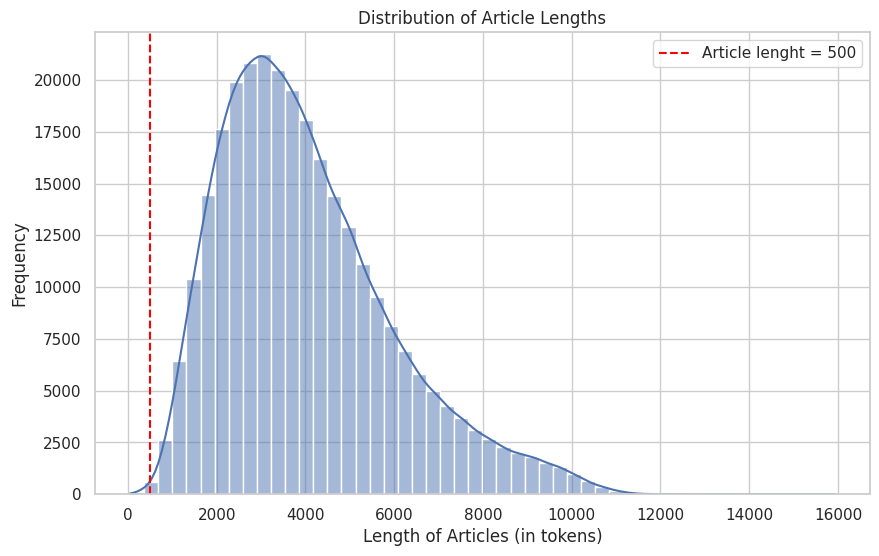

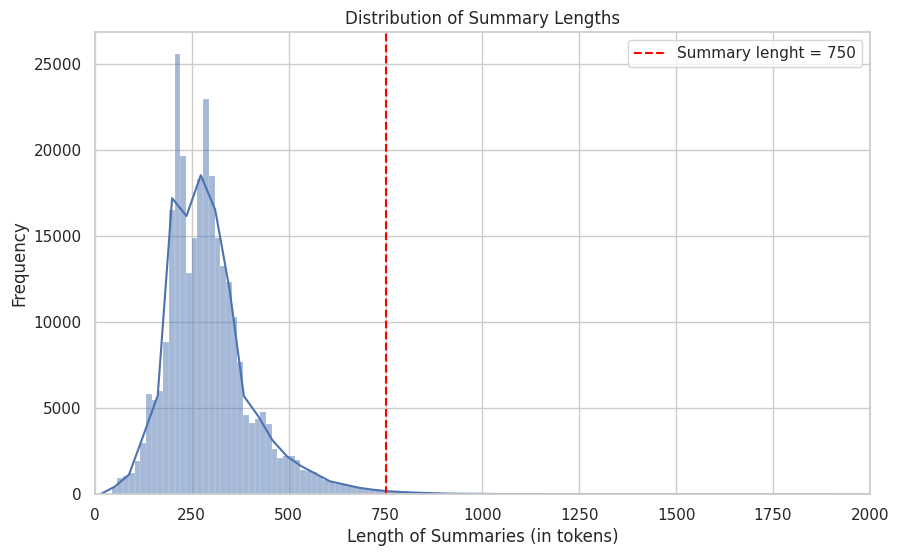

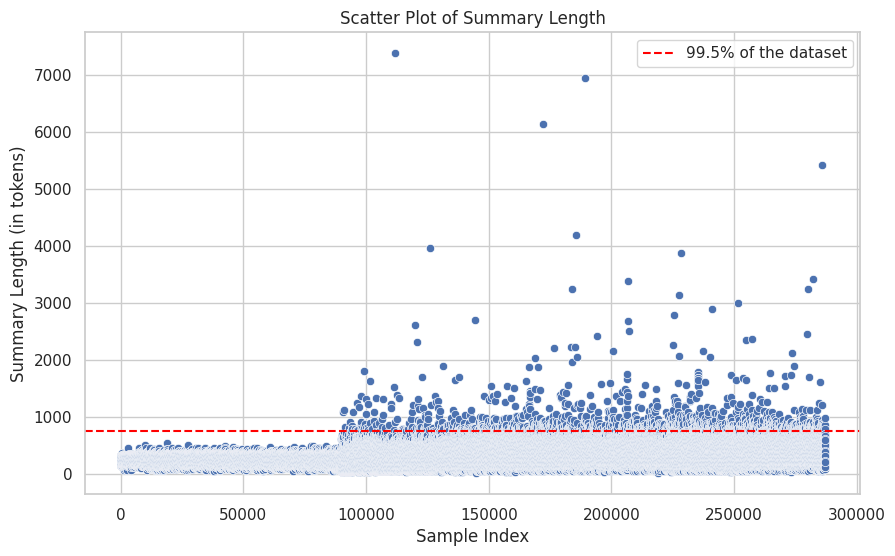

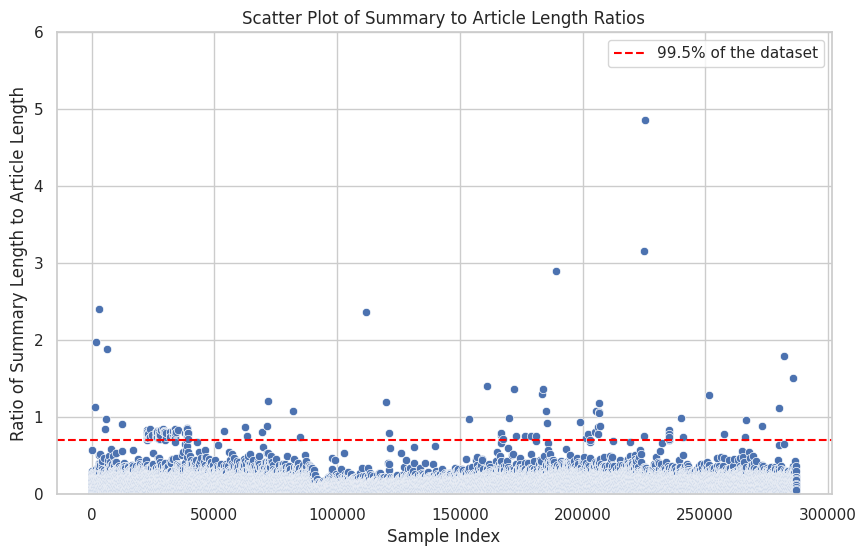

In [53]:
# Set the style of the plots
sns.set(style="whitegrid")

# Plot the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(article_lengths, bins=50, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Length of Articles (in tokens)')
vertical_line = plt.axvline(x=500, color='red', linestyle='--', label='Article lenght = 500')  # Add a vertical line at x=500 with a label
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the distribution of summary lengths
plt.figure(figsize=(10, 6))
sns.histplot(summary_lengths, bins=500, kde=True)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length of Summaries (in tokens)')
plt.xlim(0, 2000)
plt.axvline(x=750, color='red', linestyle='--', label='Summary lenght = 750')  # Add a vertical line at x=100
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create scatter plot of summary length to article length ratios
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(summary_lengths)), y=summary_lengths)
plt.title('Scatter Plot of Summary Length')
plt.xlabel('Sample Index')
plt.ylabel('Summary Length (in tokens)')
plt.axhline(750, color='red', linestyle='--', label='99.5% of the dataset')  # Add a dotted red horizontal line at y=1
plt.legend()
plt.show()

length_ratios = np.array(length_ratios)

# Create scatter plot of summary length to article length ratios
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(length_ratios)), y=length_ratios)
plt.title('Scatter Plot of Summary to Article Length Ratios')
plt.xlabel('Sample Index')
plt.ylabel('Ratio of Summary Length to Article Length')
plt.ylim(0, 6)  # Adjust the y-axis limits to focus on the range between 0 and 1
plt.axhline(0.7, color='red', linestyle='--', label='99.5% of the dataset')  # Add a dotted red horizontal line at y=1
plt.legend()
plt.show()

Red dotted lines are showcasing the potential frontiere to keep/remove the data.

We are trying the same this with the test set.

In [58]:
dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')
n = len(dataset)

article_lengths = []
summary_lengths = []
length_ratios = []

for i in tqdm(range(n)):
    article_lengths.append(len(dataset[i]['article']))
    summary_lengths.append(len(dataset[i]['highlights']))
    length_ratios.append(len(dataset[i]['highlights']) / len(dataset[i]['article']))

100%|██████████| 11490/11490 [00:01<00:00, 7428.37it/s]


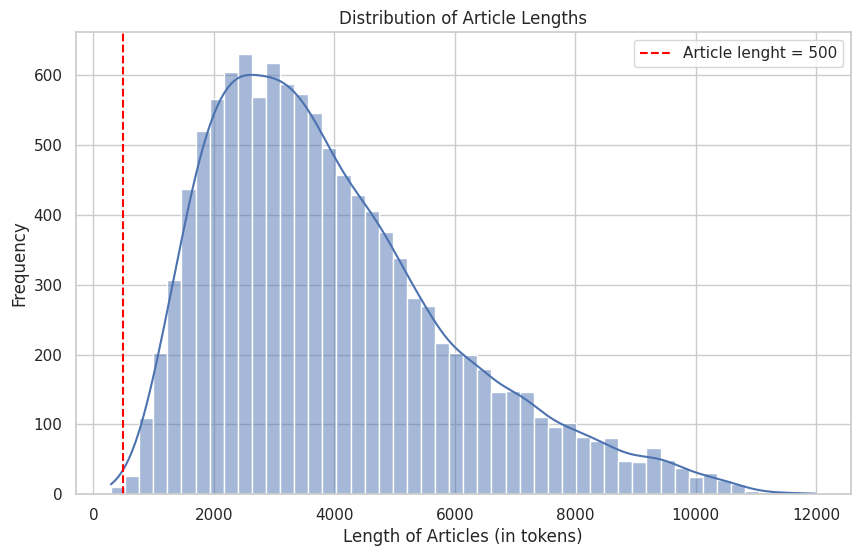

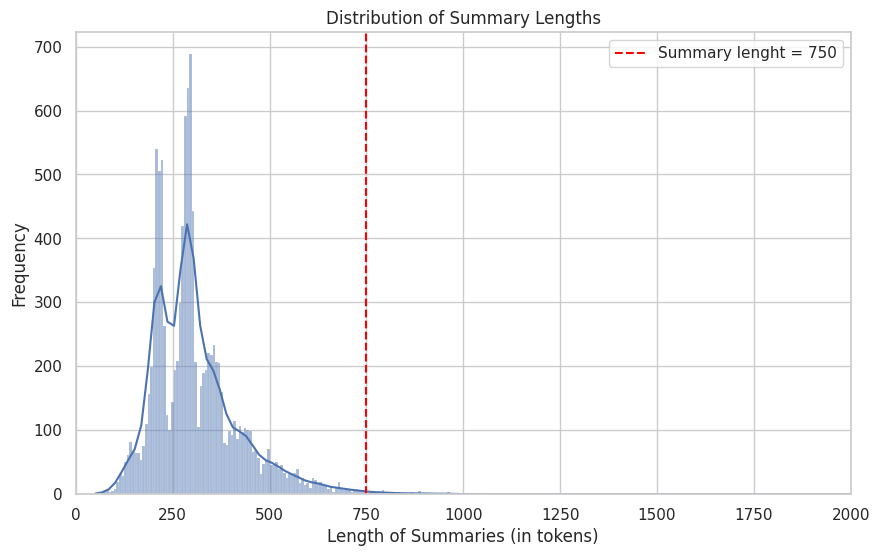

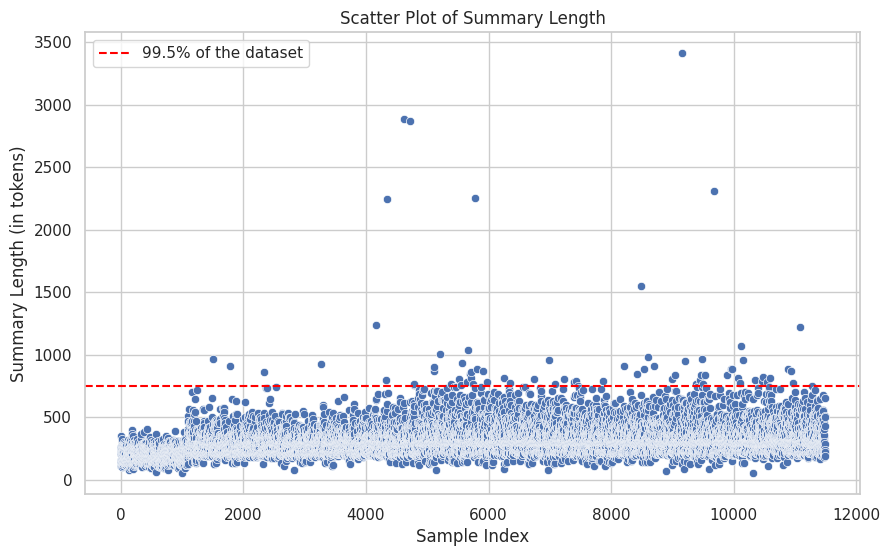

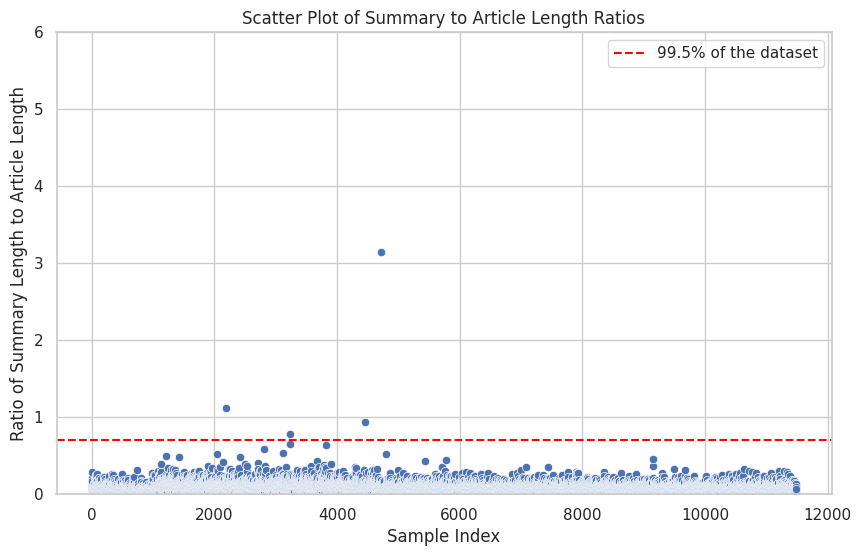

In [59]:
# Set the style of the plots
sns.set(style="whitegrid")

# Plot the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(article_lengths, bins=50, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Length of Articles (in tokens)')
vertical_line = plt.axvline(x=500, color='red', linestyle='--', label='Article lenght = 500')  # Add a vertical line at x=500 with a label
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the distribution of summary lengths
plt.figure(figsize=(10, 6))
sns.histplot(summary_lengths, bins=500, kde=True)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length of Summaries (in tokens)')
plt.xlim(0, 2000)
plt.axvline(x=750, color='red', linestyle='--', label='Summary lenght = 750')  # Add a vertical line at x=100
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create scatter plot of summary length to article length ratios
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(summary_lengths)), y=summary_lengths)
plt.title('Scatter Plot of Summary Length')
plt.xlabel('Sample Index')
plt.ylabel('Summary Length (in tokens)')
plt.axhline(750, color='red', linestyle='--', label='99.5% of the dataset')  # Add a dotted red horizontal line at y=1
plt.legend()
plt.show()

length_ratios = np.array(length_ratios)

# Create scatter plot of summary length to article length ratios
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(length_ratios)), y=length_ratios)
plt.title('Scatter Plot of Summary to Article Length Ratios')
plt.xlabel('Sample Index')
plt.ylabel('Ratio of Summary Length to Article Length')
plt.ylim(0, 6)  # Adjust the y-axis limits to focus on the range between 0 and 1
plt.axhline(0.7, color='red', linestyle='--', label='99.5% of the dataset')  # Add a dotted red horizontal line at y=1
plt.legend()
plt.show()

### Part 3 - Contraction words

Here, we are going to compare the vocabulary size of the different sets, and we will remove the contraction to reduce the size of the vocabulary.

In [92]:
# See http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [1]:
def count_words(count_dict, text):
    '''
    Count the number of occurrences of each word in a set of text.
    
    Inputs:
    - count_dict (dict): dictionnary containing the vocabulary
    - text (str): Text to analyze
    '''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [99]:
dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
word_counts = {}
count_words(word_counts, dataset['article'])
count_words(word_counts, dataset['highlights'])          
print("Size of Vocabulary:", len(word_counts))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Size of Vocabulary: 2097994


In [100]:
def clean_text(text):
    '''
    Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings
    
    Inputs:
    - text (str): Text to analyze
    '''
    text = text.lower()
    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\ ', ' ', text)
    text = re.sub(r'\'', ' ', text)

    return text

In [101]:
clean_highlights = []
for i in dataset['highlights']:
    clean_highlights.append(clean_text(i, remove_stopwords=False))
print("Summaries are complete.")

clean_article = []
for k in dataset['article']:
    clean_article.append(clean_text(k))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [102]:
word_counts_pruned = {}
count_words(word_counts_pruned, clean_article)
count_words(word_counts_pruned, clean_highlights)          
print("Size of Vocabulary:", len(word_counts_pruned))

Size of Vocabulary: 1619472


In [104]:
print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(word_counts_pruned))
print("Percent of words we will use: {}%".format((len(word_counts_pruned)/len(word_counts))*100))

Total number of unique words: 2097994
Number of words we will use: 1619472
Percent of words we will use: 77.19145049985843%


### Part 4 - String format (CNN)

Potentially remove the article starting differently

In [98]:
count_articles_starting_with_parenthesis = sum(article.startswith('(CNN)') for article in dataset['article'])

print(f'Number of articles starting with "(CNN)": {count_articles_starting_with_parenthesis}')

Number of articles starting with "(CNN)": 831
